# Project P3 - Feminism in movies

### Import the data

In [60]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

file_source = 'C:/Users/jacqu/OneDrive/Documents/GitHub/ada-2024-project-theadavengers/Data/'
# file_source ='/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/'
# bechdel_path2 = "/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/MovieSummaries/movies_feminism.csv"
#### Movie metadata #### DF
MovieMetadata_df = pd.read_csv(file_source +'/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

#### Character metadata #### DF
CharacterMetadata_df = pd.read_csv(file_source + '/MovieSummaries/character.metadata.tsv', sep='\t', header=None)

# Define column headers as a list
MovieMetadata_df_headers = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie name',
    'Movie release date',
    'Movie box office revenue',
    'Movie runtime',
    'Movie languages (Freebase ID:name tuples)',
    'Movie countries (Freebase ID:name tuples)',
    'Movie genres (Freebase ID:name tuples)'
]

MovieMetadata_df.columns = MovieMetadata_df_headers

# Define column headers for the second dataset
CharacterMetadata_df_headers = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character name',
    'Actor date of birth',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'Freebase character ID',
    'Freebase actor ID'
]

CharacterMetadata_df.columns = CharacterMetadata_df_headers

# Text data 
names_df = pd.read_csv(file_source+'MovieSummaries/name.clusters.txt', sep="\t", header=None)
plot_summaries_df = pd.read_csv(file_source+'MovieSummaries/plot_summaries.txt', sep="\t", header=None)
tvTropes_df = pd.read_csv(file_source+'MovieSummaries/tvtropes.clusters.txt', sep="\t", header=None)

names_df_headers = [
    'Character Names',
    'Instances'
]

names_df.columns = names_df_headers

tvTropes_df_headers = [
    'Character Types',
    'Instances'
]

tvTropes_df.columns = tvTropes_df_headers


plot_summaries_df_headers = [
    'Wikipedia movie ID',
    'Summaries'
]

plot_summaries_df.columns = plot_summaries_df_headers

# Create a dataframe with the bechdel data as well as plots
bechdel_data2 = pd.read_csv('Data\Bechdel_IMDB_Merge0524.csv')
# drop the NaN movie plots
plot_summaries_df = plot_summaries_df.dropna(subset=['Summaries'])

imdb_df = pd.read_csv('Data/imdb_movies.csv')

MovieMetadata_df = MovieMetadata_df.merge(plot_summaries_df, on='Wikipedia movie ID', how='inner')
MovieMetadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Summaries
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


### Train an SVM on a made-up metric

**Compute the percentage of women characters/actor in a movie (in the IMDB dataset)**

In [61]:
import pandas as pd
import gender_guesser.detector as gender

# Initialize gender detector
detector = gender.Detector()

# Load the dataset
file_path = 'Data/imdb_movies.csv'  # Replace with the actual path to your file
imdb_movies = pd.read_csv(file_path)

# Function to extract only actor names (every other item in the list, starting with the first)
def extract_actor_names(crew_string):
    if pd.isna(crew_string):
        return []
    # Split the string by commas
    crew_list = crew_string.split(',')
    # Strip whitespace and filter out empty strings
    crew_list = [item.strip() for item in crew_list if item.strip()]
    # Take every other element starting with the first as actor names
    actor_names = crew_list[::2]
    return actor_names

# Apply the function to extract actor names
imdb_movies['actor_names'] = imdb_movies['crew'].apply(extract_actor_names)

# Flatten the list of actor names for gender inference
all_actor_names = [name for sublist in imdb_movies['actor_names'] for name in sublist]

# Infer gender for each unique actor name
name_to_gender = {name: detector.get_gender(name.split()[0]) for name in set(all_actor_names)}

# Function to infer genders for a list of actor names
def infer_genders(actor_names):
    return [name_to_gender.get(name, 'unknown') for name in actor_names]

# Apply gender inference to the actor names
imdb_movies['genders'] = imdb_movies['actor_names'].apply(infer_genders)

# Calculate the proportion of female actors per movie
def calculate_female_proportion(gender_list):
    if len(gender_list) == 0:
        return 0
    female_count = sum(1 for gender in gender_list if gender in ['female', 'mostly_female'])
    return female_count / len(gender_list)

imdb_movies['female_proportion'] = imdb_movies['genders'].apply(calculate_female_proportion)

In [62]:
# Create a metric in the merged_df that is bechdel_rating+3*female_proportion

# Merge the bechdel columns that we need
bechdel_df = bechdel_data2[['title', 'bechdelRating']].copy()
bechdel_df.columns = ['Movie name', 'Bechdel rating']
merged_df = MovieMetadata_df.merge(bechdel_df, on='Movie name', how='inner')
merged_df = merged_df.merge(plot_summaries_df, on='Wikipedia movie ID', how='inner')
merged_df['Bechdel rating'] = (merged_df['Bechdel rating'] == 3).astype(int)

# Merge the imdb columns that we need
imdb_utility_df = imdb_movies[['names', 'female_proportion']].copy()
imdb_utility_df.columns = ['Movie name', 'Female proportion']
merged_df = merged_df.merge(imdb_utility_df, on='Movie name', how='inner')
print('Merged dataframe has', merged_df.shape[0], 'movies.')

# Create the metric
merged_df['Custom metric'] = merged_df['Bechdel rating'] + merged_df['Female proportion']
merged_df.head()

Merged dataframe has 4039 movies.


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Summaries_x,Bechdel rating,Summaries_y,Female proportion,Custom metric
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",1,"Set in the second half of the 22nd century, th...",0.444444,1.444444
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,1,The film opens with Mary Poppins perched in a...,0.444444,1.444444
2,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...","In the heart of the Canadian wilderness, sultr...",1,"In the heart of the Canadian wilderness, sultr...",0.111111,1.111111
3,1765938,/m/05v5ws,Convoy,1978,45000000.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...","{{Plot}} Truck driver Martin ""Rubber Duck"" Pen...",0,"{{Plot}} Truck driver Martin ""Rubber Duck"" Pen...",0.222222,0.222222
4,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama""}","David Sumner , a timid American mathematician,...",0,"David Sumner , a timid American mathematician,...",0.222222,0.222222


**Train a SVM model**

In [63]:
from sklearn.model_selection import train_test_split

binary_feminist_list = (merged_df['Custom metric'] >= 1.5).astype(int)
print(merged_df[merged_df['Custom metric'] >= 1.5].shape)
print(merged_df[merged_df['Custom metric'] < 1.5].shape)

# X contains features; y contains the target variable
X = merged_df[['Custom metric']]
y = binary_feminist_list

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(463, 14)
(3576, 14)


In [64]:
from sklearn.svm import SVC

# Initialize and train the SVM
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Get a prediction using SVM with the previous metric
merged_df['SVM prediction'] = model.predict(merged_df[['Custom metric']])

Confusion Matrix:
[[713   0]
 [  0  95]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       713
           1       1.00      1.00      1.00        95

    accuracy                           1.00       808
   macro avg       1.00      1.00      1.00       808
weighted avg       1.00      1.00      1.00       808



### Now use the previous classification to train a model on the plot summaries to apply to all the movies

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

# Initialize the vectorizer
vectorizer = CountVectorizer()

# Create bag of words features
X = vectorizer.fit_transform(merged_df['Summaries_x'])

# Save the vectorizer after training
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print('Number of samples in X', X.toarray().shape[0])

Y = np.array(merged_df['SVM prediction']) == 1
Y = Y.astype(int)

print('Number of samples in Y', Y.shape[0])

# Shuffle the data
X, Y = shuffle(X, Y, random_state=42)

# Balance the data
rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)

print('Resampled X shape', X.shape)
print('Resampled Y shape', len(Y))

# Split into training and testing set
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples in X 4039
Number of samples in Y 4039
Resampled X shape (926, 40956)
Resampled Y shape 926


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train a SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_2, Y_train_2)

# Predict with this SVM model
y_pred_2 = svm_model.predict(X_test_2)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(Y_test_2, y_pred_2))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        99
           1       0.72      0.69      0.71        87

    accuracy                           0.73       186
   macro avg       0.73      0.73      0.73       186
weighted avg       0.73      0.73      0.73       186



***Apply this SVM model to the original dataset to predict on all of the movies***

In [68]:
# Later, load the vectorizer for reuse
with open("vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

# Create the data to apply the model on
X_apply = loaded_vectorizer.transform(MovieMetadata_df['Summaries'])

# Apply the SVM model
y_pred_full = svm_model.predict(X_apply)

***Visualize the proportion of feminist movies in time***

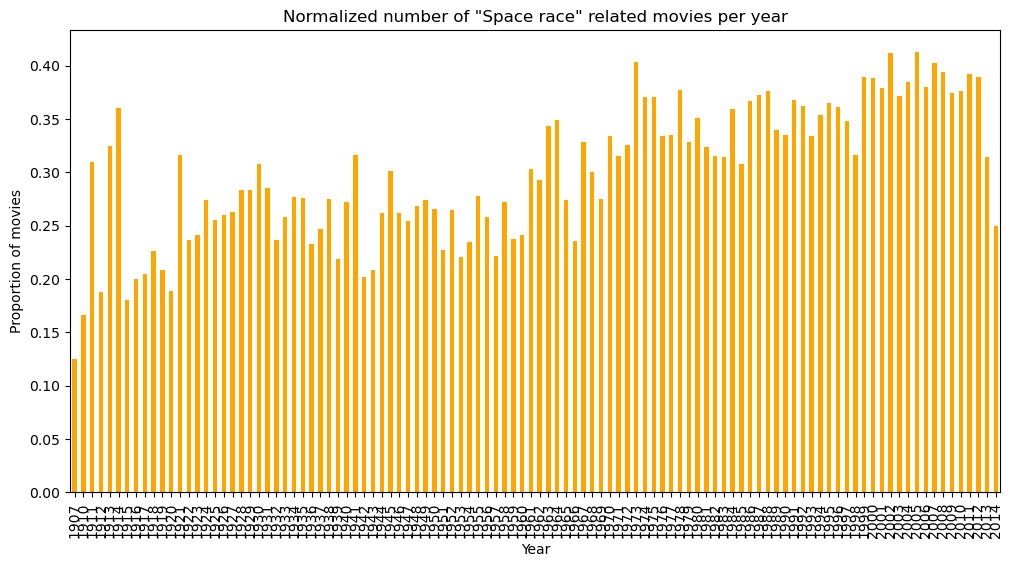

In [69]:
MovieMetadata_df['Movie release date'] = MovieMetadata_df['Movie release date'].apply(
    lambda x: x[:4] if isinstance(x, str) and len(x) > 4 else x
)

MovieMetadata_df['Feminism prediction'] = y_pred_full

# Separate the feminist movies
feminist_movies_df = MovieMetadata_df[MovieMetadata_df['Feminism prediction'] == 1]

# Get rid of the outliers
feminist_movies_df = feminist_movies_df.dropna(subset=['Movie release date'])
feminist_movies_df['Movie release date'] = feminist_movies_df['Movie release date'].astype(int)
feminist_movies_df = feminist_movies_df[feminist_movies_df['Movie release date'] > 1904]

# Count the number of feminist movies per year
feminist_movies_per_year = feminist_movies_df['Movie release date'].value_counts().sort_index()
feminist_movies_per_year.index = feminist_movies_per_year.index.astype(int)

# Clean the outliers in the full dataframe
MovieMetadata_df = MovieMetadata_df.dropna(subset=['Movie release date'])
MovieMetadata_df['Movie release date'] = MovieMetadata_df['Movie release date'].astype(int)
MovieMetadata_df = MovieMetadata_df[MovieMetadata_df['Movie release date'] > 1904]

# Count the number of movies per year
movies_per_year = MovieMetadata_df['Movie release date'].value_counts().sort_index()
movies_per_year.index = movies_per_year.index.astype(int)

# Normalize by number of movies each year
feminist_movies_per_year_normal = feminist_movies_per_year/movies_per_year

# Filter the NaN parameters
feminist_movies_per_year_normal = feminist_movies_per_year_normal.dropna()
feminist_movies_per_year_normal.index = feminist_movies_per_year_normal.index.astype(int)

# Plotting
plt.figure(figsize=(12, 6))
feminist_movies_per_year_normal.plot(kind='bar', color='orange')
plt.title('Normalized number of "Space race" related movies per year')
plt.xlabel('Year')
plt.ylabel('Proportion of movies')

plt.show()

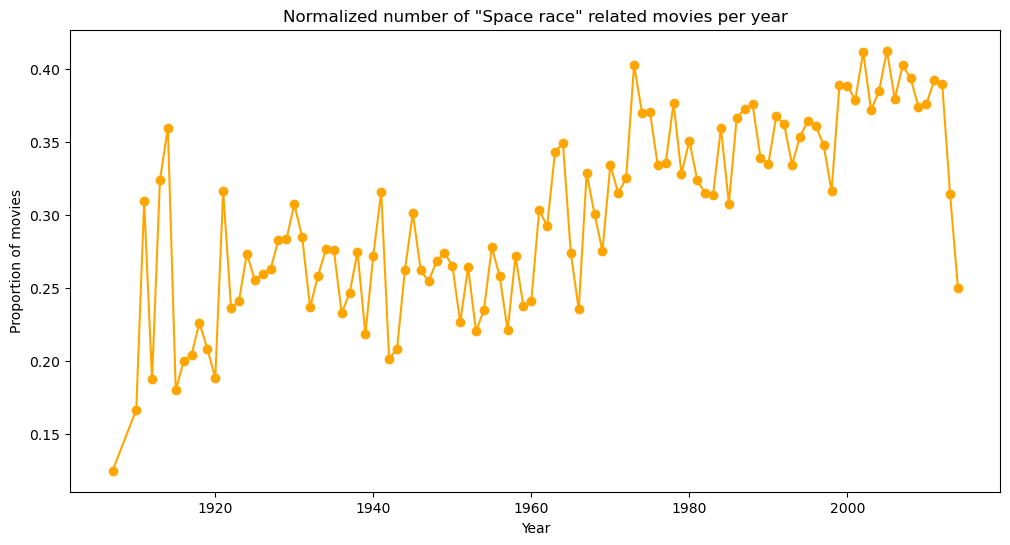

In [70]:
# Plotting
plt.figure(figsize=(12, 6))
feminist_movies_per_year_normal.plot(kind='line', color='orange', marker='o')
plt.title('Normalized number of "Space race" related movies per year')
plt.xlabel('Year')
plt.ylabel('Proportion of movies')

plt.show()

### Apply a linear regression to the previous point to determine a tendency

In [71]:
from sklearn.linear_model import LinearRegression

# Define the variables for the lienar regression
X_linear = feminist_movies_per_year_normal.index
X_linear = np.array(X_linear)
X_linear = X_linear.reshape(-1, 1)
y_linear = feminist_movies_per_year_normal.values

# Define and fit the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_linear, y_linear)

# Predict using the linear regression model
y_linear_pred = lin_model.predict(X_linear)

# Compute the correlation coefficient 
corr = np.corrcoef(X_linear.flatten(), y_linear)
print("Correlation coefficient :", corr[0,1])

Correlation coefficient : 0.7655444631437078


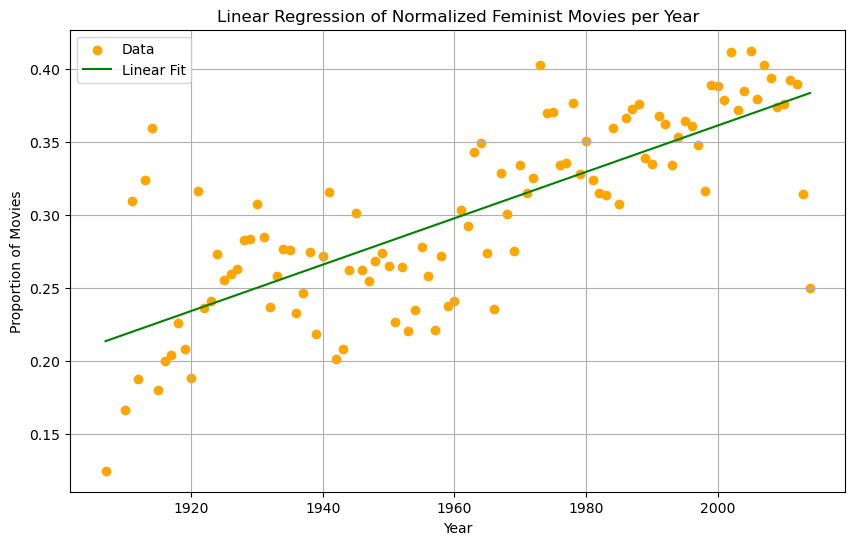

In [72]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_linear, y_linear, color='orange', label='Data')
plt.plot(X_linear, y_linear_pred, color='green', label='Linear Fit')
plt.title('Linear Regression of Normalized Feminist Movies per Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
MovieMetadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Summaries,Feminism prediction
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",0
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,1
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra...",0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...",0
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...",1


### Try to train a random forest to find the ingredients for a feminist movie

In [ ]:
def find_freebase(s):
    try:
        start_idx = s.index(': "') + len(': "')
        end_idx = s.index('"', start_idx)
        #print(start_idx, end_idx)
        return s[start_idx:end_idx]
    except ValueError:
        return ""
    
# Merge the imdb columns that we need
imdb_utility_df = imdb_movies[['names', 'female_proportion']].copy()
imdb_utility_df.columns = ['Movie name', 'Female proportion']
#MovieMetadata_df = MovieMetadata_df.merge(imdb_utility_df, on='Movie name', how='inner')
print('Merged dataframe has', merged_df.shape[0], 'movies.')

#MovieMetadata_df['Main genre'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: find_freebase(x))
#MovieMetadata_df['Main country'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: find_freebase(x))
#MovieMetadata_df['Main language'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: find_freebase(x))
#MovieMetadata_df = MovieMetadata_df.drop(columns=['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)'])
MovieMetadata_df = MovieMetadata_df.drop(columns=['Female proportion_x'])


print(MovieMetadata_df.shape)

Merged dataframe has 4039 movies.
(30067, 12)


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Summaries,Feminism prediction,Main genre,Main country,Main language,Female proportion
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"Set in the second half of the 22nd century, th...",0,Thriller,United States of America,English Language,0.444444
1,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"Every hundred years, the evil Morgana returns...",0,Family Film,South Africa,English Language,0.333333
2,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,The film opens with Mary Poppins perched in a...,0,Children's/Family,United States of America,English Language,0.444444
3,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,The film is a collision of three separate stor...,1,Adventure,South Africa,Afrikaans Language,0.111111
4,1254263,/m/04mhwd,Shivers,1975,NaN,89.0,Dr. Emil Hobbes is conducting unorthodox expe...,0,Science Fiction,Canada,English Language,0.444444


In [81]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Preprocessing
# Encode categorical data (e.g., genres)
genres_encoded = MovieMetadata_df['Main genre'].str.get_dummies(sep=',')  # One-hot encode genres

# Scale numerical features (e.g., Female proportion, Bechdel test rating)
scaler = StandardScaler()
MovieMetadata_df[['Female proportion']] = scaler.fit_transform(
    MovieMetadata_df[['Female proportion']]
)

# Text vectorization for plot summaries
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 500 features
plot_tfidf = tfidf_vectorizer.fit_transform(MovieMetadata_df['Summaries'].fillna("")).toarray()

In [ ]:
# Combine all features
X = np.hstack([genres_encoded, MovieMetadata_df[['Female proportion']], plot_tfidf])
y = MovieMetadata_df['Feminism prediction'].values  # Target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Analyze feature importance
feature_names = list(genres_encoded.columns) + ['Female proportion'] + list(tfidf_vectorizer.get_feature_names_out())
feature_importances = rf_model.feature_importances_

Test Accuracy: 95.76%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4589
           1       0.99      0.83      0.90      1425

    accuracy                           0.96      6014
   macro avg       0.97      0.91      0.94      6014
weighted avg       0.96      0.96      0.96      6014

Top 10 Important Features:
Female proportion: 0.0198
and: 0.0089
abuse: 0.0086
her: 0.0084
love: 0.0082
marry: 0.0070
she: 0.0066
to: 0.0060
years: 0.0059
wife: 0.0059


C:\Users\jacqu\AppData\Local\Temp\ipykernel_22680\2523421362.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=importance_names, palette="viridis")


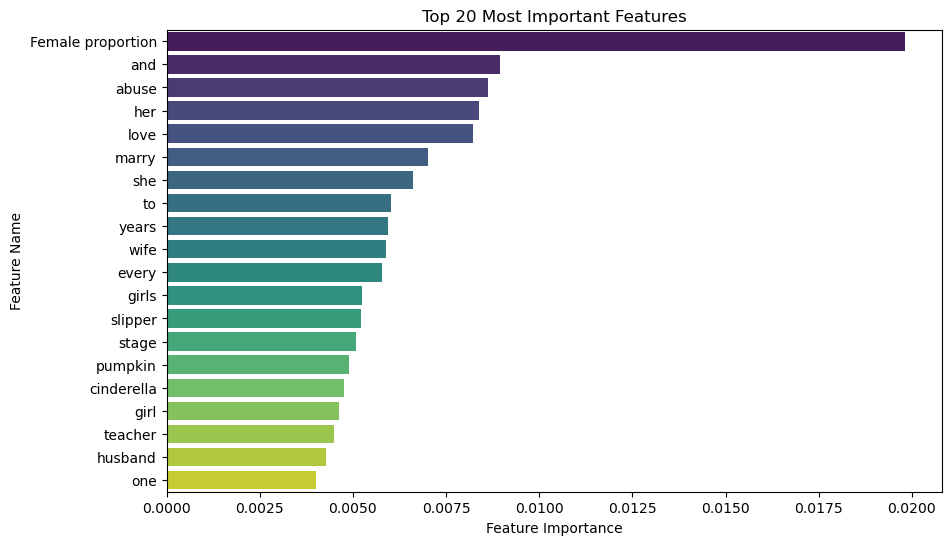

In [83]:
import seaborn as sns

# Top 20 important features
important_features = sorted(zip(feature_importances, feature_names), reverse=True)[:20]
importance_values, importance_names = zip(*important_features)

# Visualization of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_values, y=importance_names, palette="viridis")
plt.title("Top 20 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

C:\Users\jacqu\AppData\Local\Temp\ipykernel_22680\868635923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=MovieMetadata_df['Female proportion'], palette="coolwarm")


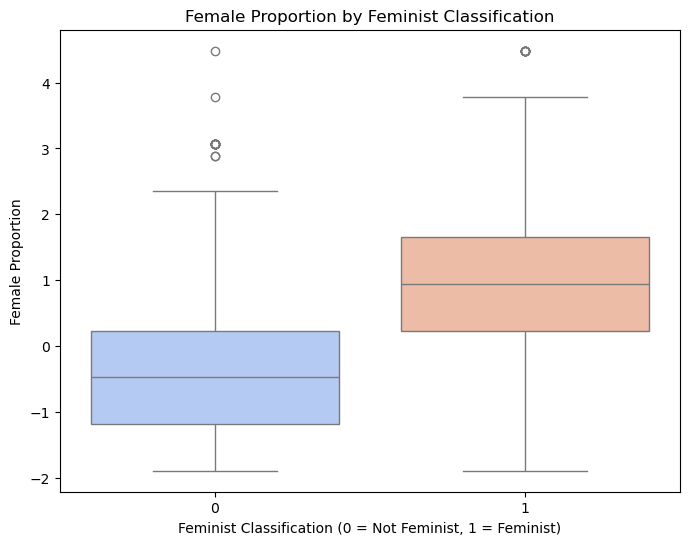

In [84]:
# Analyze relationships of key features
# Example: Plot Female Proportion vs. Feminist Classification
plt.figure(figsize=(8, 6))
sns.boxplot(x=y, y=MovieMetadata_df['Female proportion'], palette="coolwarm")
plt.title("Female Proportion by Feminist Classification")
plt.xlabel("Feminist Classification (0 = Not Feminist, 1 = Feminist)")
plt.ylabel("Female Proportion")
plt.show()

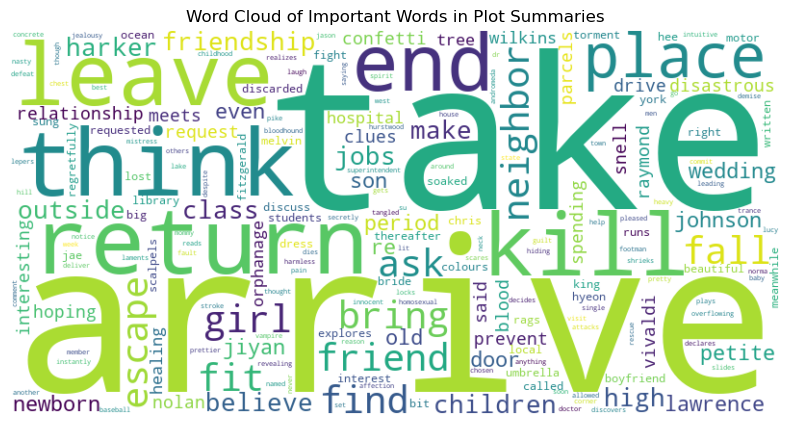

In [85]:
# Word Cloud of Important Words from Plot Summaries
from wordcloud import WordCloud

# Get top TF-IDF terms contributing to feminist classification
top_words_indices = np.argsort(rf_model.feature_importances_)[-500:]  # Assume the last 500 features are TF-IDF
top_words = [feature_names[i] for i in top_words_indices if feature_names[i] not in genres_encoded.columns]

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(top_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Important Words in Plot Summaries")
plt.show()